In [39]:
import pandas as pd
import os

In [40]:
os.listdir()

['disease_cause.csv',
 'Untitled.ipynb',
 'disease_specialty.csv',
 'embeddigs_diseases.csv',
 '.ipynb_checkpoints',
 'disease_symptoms.csv']

In [45]:
df1 = pd.read_csv('disease_cause.csv')
df2 = pd.read_csv('disease_specialty.csv')
df3 = pd.read_csv('disease_symptoms.csv')

In [46]:
final_df=pd.concat([df1,df2,df3])

final_df.to_csv('embeddigs_diseases.csv',index=False)

In [43]:
final_df

,subject,predicate,object
0,"""encephalitis""",Cause,"""rabies"""
1,"""bacterial vaginosis""",Cause,"""Gardnerella vaginalis"""
2,"""obsolete adenovirus infectious disease""",Cause,"""Adenoviridae"""
3,"""spinal stenosis""",Cause,"""spondylosis"""
4,"""endemic goiter""",Cause,"""iodine deficiency"""
...,...,...,...
1627,"""primary amebic meningoencephalitis""",Symptom,"""ulcer"""
1628,"""Crohn's disease""",Symptom,"""ulcer"""
1629,"""acrodermatitis enteropathica""",Symptom,"""alopecia"""
1630,"""Lassa fever""",Symptom,"""alopecia"""


In [59]:
import ampligraph
import numpy as np

In [49]:
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.datasets import load_from_csv


In [54]:
X = load_from_csv('.','embeddigs_diseases.csv',sep=',')

In [57]:
X.shape[0]

9552

In [64]:
X_train, X_valid = train_test_split_no_unseen(np.array(X), test_size=int(X.shape[0]/10))

In [65]:
X_train

array([[' "encephalitis" ', 'Cause', ' "rabies" '],
       [' "bacterial vaginosis" ', 'Cause', ' "Gardnerella vaginalis" '],
       [' "obsolete adenovirus infectious disease" ', 'Cause',
        ' "Adenoviridae" '],
       ...,
       [' "acrodermatitis enteropathica" ', 'Symptom', ' "alopecia" '],
       [' "Lassa fever" ', 'Symptom', ' "alopecia" '],
       [' "mercury poisoning" ', 'Symptom', ' "proteinuria" ']],
      dtype=object)

In [66]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)


Train set size:  (8597, 3)
Test set size:  (955, 3)


In [67]:
from ampligraph.latent_features import ComplEx

model = ComplEx(batches_count=50,
                epochs=300,
                k=100,
                eta=20,
                optimizer='adam', 
                optimizer_params={'lr':1e-4},
                loss='multiclass_nll',
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                seed=0, 
                verbose=True)

In [68]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train)


Average Loss:   0.361013: 100%|██████████| 300/300 [05:46<00:00,  1.15s/epoch]


In [70]:
from ampligraph.evaluation import evaluate_performance
filter_triples = np.concatenate((X_train, X_valid))
ranks = evaluate_performance(X_valid,
                             model=model, 
                             filter_triples=filter_triples,
                             use_default_protocol=True,
                             verbose=True)

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 955/955 [00:20<00:00, 47.47it/s]


In [71]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))


MRR: 0.08
MR: 2043.11
Hits@10: 0.17
Hits@3: 0.09
Hits@1: 0.04


In [ ]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

In [125]:
diseases =np.array(list(set(X_train[:,0])))
disease_embeddings = dict(zip(diseases, model.get_embeddings(diseases)))
len(diseases)

6151

In [126]:
len(dict(zip(diseases,(model.get_embeddings(diseases)))))

6151

In [127]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in disease_embeddings.values()]))


(9552, 3)

In [174]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans,DBSCAN

clustering_algorithm = DBSCAN()
clusters = find_clusters(diseases, model, clustering_algorithm, mode='entity')

In [201]:
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58])

In [181]:
plot_df = pd.DataFrame({"diseases": diseases, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

In [156]:
def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(20, 15))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df[plot_df.diseases!="unk"].iloc[0:20], x="embedding1", y="embedding2", hue=hue)
    data=plot_df[plot_df.diseases!="unk"].iloc[0:20]
    texts = []
    for i, point in data.iterrows():
        texts.append(plt.text(point['embedding1']+0.02, point['embedding2']+0.01, str(point["diseases"])))
    

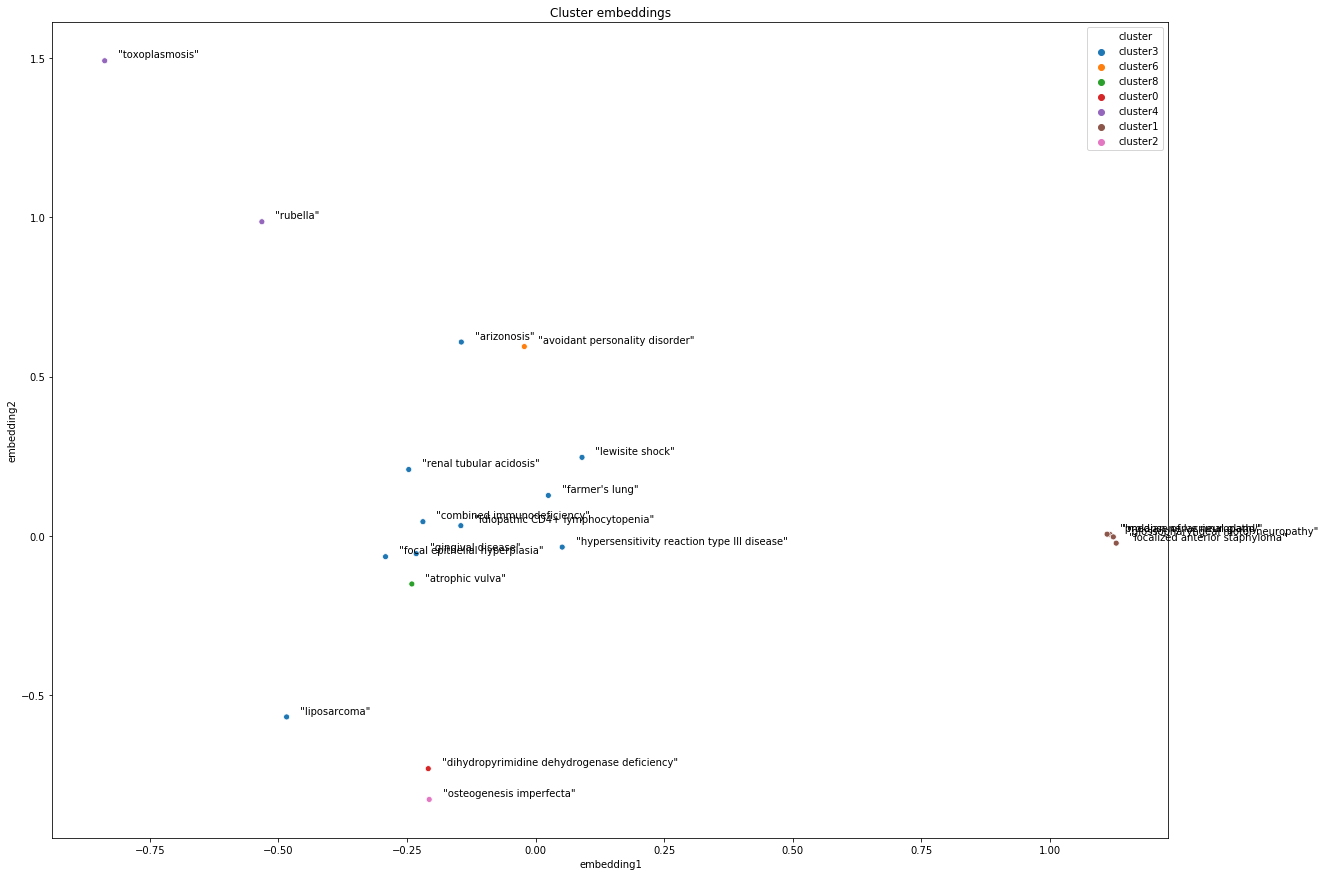

In [157]:
plot_clusters('cluster')

In [205]:
plot_df[plot_df['cluster']=='cluster7']

,diseases,embedding1,embedding2,cluster
12,"""arizonosis""",-0.144345,0.608246,cluster7
178,"""baylisascariasis""",-0.167976,0.580644,cluster7
225,"""mesocestoidiasis""",-0.198233,0.648878,cluster7
661,"""Acinetobacter infectious disease""",-0.177107,0.622956,cluster7
862,"""human immunodeficiency virus infectious dise...",-0.167608,0.632806,cluster7
1231,"""Polyomavirus-associated Nephropathy""",-0.144526,0.594836,cluster7
1232,"""black piedra""",-0.178518,0.616393,cluster7
1280,"""cysticercosis""",-0.183762,0.639975,cluster7
1323,"""spiruridiasis""",-0.184757,0.604131,cluster7
1426,"""Monieziosis""",-0.193924,0.601437,cluster7


In [191]:
plot_df[plot_df['cluster']=='cluster-2']

,diseases,embedding1,embedding2,cluster
